№5

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['seg_train', 'seg_pred', 'seg_test']


In [2]:
!ls ../input

seg_pred  seg_test  seg_train


In [3]:
import torch
from torch import nn
from torchvision import datasets, models, transforms


In [4]:
import torch.utils.data as tdata

In [5]:
!ls ../input/seg_train/seg_train/
!ls ../input/seg_test/seg_test/

buildings  forest  glacier  mountain  sea  street
buildings  forest  glacier  mountain  sea  street


In [6]:
data_path_format = '../input/seg_{0}/seg_{0}'

In [7]:
np.random.seed(5315)
torch.manual_seed(9784)

In [8]:
channel_means = (0.485, 0.456, 0.406)
channel_stds = (0.229, 0.224, 0.225)

In [9]:
image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_stds)
])
    

In [10]:
image_datasets = dict(zip(('dev', 'test'), [datasets.ImageFolder(data_path_format.format(key),transform=image_transforms) for key in ['train', 'test']]))
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None}


In [11]:
devset_indices = np.arange(len(image_datasets['dev']))
devset_labels = image_datasets['dev'].targets

In [12]:
from sklearn import model_selection

In [13]:
train_indices, val_indices, train_labels,  val_labels = model_selection.train_test_split(devset_indices, devset_labels, test_size=0.1, stratify=devset_labels)

In [14]:
print(len(val_indices))

1404


In [15]:
image_datasets['train'] = tdata.Subset(image_datasets['dev'], train_indices)
image_datasets['validation'] = tdata.Subset(image_datasets['dev'], val_indices)

In [16]:
print(image_datasets)

{'dev': Dataset ImageFolder
    Number of datapoints: 14034
    Root Location: ../input/seg_train/seg_train
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'test': Dataset ImageFolder
    Number of datapoints: 3000
    Root Location: ../input/seg_test/seg_test
    Transforms (if any): Compose(
                             Resize(size=(150, 150), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None, 'train': <torch.utils.data.dataset.Subset object at 0x7f95a5015f98>, 'validation': <torch.utils.data.dataset.Subset object at 0x7f95a5015f60>}


In [17]:
from IPython.display import display

In [18]:
image_dataloaders = {key: tdata.DataLoader(image_datasets[key], batch_size=16,shuffle=True) for key in  ['train', 'validation']}

In [19]:
image_dataloaders['test'] = tdata.DataLoader(image_datasets['test'], batch_size=32)

In [20]:
def imshow(inp, title=None, fig_size=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0)) # C x H x W  # H x W x C
    inp = channel_stds * inp + channel_means
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=fig_size)
    ax = fig.add_subplot('111')
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.set_aspect('equal')
    plt.pause(0.001)  

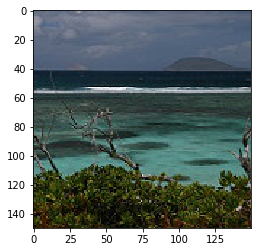

In [21]:
imshow(image_datasets['train'][8555][0]) # 5946

In [22]:
cuda_device = torch.device('cuda')
cpu_device = torch.device('cpu')
device = cuda_device

In [23]:
class neuralNet(nn.Module):
    def __init__(self):
        super(neuralNet, self).__init__()
        self.cv1 = nn.Conv2d(3, 30, 3, stride=1, padding=0)
        self.mpool1 = nn.MaxPool2d(2, 2)
        self.cv2 = nn.Conv2d(30, 60, 3, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        self.cvt1 = nn.ConvTranspose2d(60, 80, 3, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        self.mpool2 = nn.MaxPool2d(2, 2)
        self.cv3 = nn.Conv2d(80, 110, 3, stride=1, padding=0)
        self.relu3 = nn.ReLU()
        self.mpool3 = nn.MaxPool2d(2, 2)
        self.cv4 = nn.Conv2d(110, 120, 3, stride=1, padding=0)
        self.relu4 = nn.ReLU()
        
        self.fc = nn.Linear(120 * 15 * 15, 6)
       
    def forward(self, x):
        x = self.cv1(x)
        x = self.mpool1(x)
        x = self.cv2(x)
        x = self.relu1(x)
        x = self.cvt1(x)
        x = self.relu2(x)
        x = self.mpool2(x)
        x = self.cv3(x)
        x = self.relu3(x)
        x = self.mpool3(x)
        x = self.cv4(x)
        x = self.relu4(x)
        
        x = x.view(x.size(0), 120 * 15 * 15)
        
        x = self.fc(x)
        return x

In [24]:
ptr = neuralNet()
ptr = ptr.to(device)

In [25]:
class BestModel:
    def __init__(self, path, initial_criterion):
        self.path = path
        self.criterion = initial_criterion
        
    def update(self, model, optimizer, criterion):
        self.criterion = criterion
        torch.save({'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict(), 'criterion': criterion}, self.path)
        
    def load_model_data(self):
        return torch.load(self.path)
    
    def restore(self, model, optimizer):
        model_data = self.load_model_data()
        model.load_state_dict(model_data['model_state'])
        optimizer.load_state_dict(model_data['optimizer_state'])

In [26]:
def train_model(epochs, model, optimizer, criterion, loaders, device, best_model, n_prints=1):
    print_every = len(loaders['train']) // n_prints
    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        
        for iteration, (xx, yy) in enumerate(loaders['train']):
            optimizer.zero_grad()
            xx, yy = xx.to(device), yy.to(device)
            out = model(xx)
            loss = criterion(out, yy)
            running_train_loss += loss.item()
            loss.backward()
            optimizer.step()
            
            if(iteration % print_every == print_every - 1):
                running_train_loss /= print_every
                print(f"Epoch {epoch}, iteration {iteration} training_loss {running_train_loss}")
                running_train_loss = 0.0
            
        with torch.no_grad():
            model.eval()
            running_corrects = 0
            running_total = 0
            running_loss = 0.0
            for xx, yy in loaders['validation']:
                batch_size = xx.size(0)
                xx, yy = xx.to(device), yy.to(device)

                out = model(xx)
                
                loss = criterion(out, yy)
                running_loss += loss.item()
                
                predictions = out.argmax(1)
                running_corrects += (predictions == yy).sum().item()
                running_total += batch_size
            
            mean_val_loss = running_loss / len(loaders['validation'])
            accuracy = running_corrects / running_total
            
            if accuracy > best_model.criterion:
                best_model.update(model, optimizer, accuracy)
            
            print(f"Epoch {epoch}, val_loss {mean_val_loss}, accuracy = {accuracy}")
    best_model.restore(model, optimizer)
                
                
            
        

In [27]:
import time
start = time.time()

In [28]:
optimizer = torch.optim.Adam(ptr.parameters(), lr=0.0003)
criterion = nn.CrossEntropyLoss()
best_model = BestModel('resnet_data',0.0)
train_model(5, ptr, optimizer, criterion,image_dataloaders, device, best_model=best_model, n_prints=5)

Epoch 0, iteration 157 training_loss 1.1918260722975187
Epoch 0, iteration 315 training_loss 0.9360334622331813
Epoch 0, iteration 473 training_loss 0.8957498333876646
Epoch 0, iteration 631 training_loss 0.842652927093868
Epoch 0, iteration 789 training_loss 0.7595170879665809
Epoch 0, val_loss 0.6829368231648748, accuracy = 0.7471509971509972
Epoch 1, iteration 157 training_loss 0.6864734988046598
Epoch 1, iteration 315 training_loss 0.6547408932937852
Epoch 1, iteration 473 training_loss 0.6172608695452726
Epoch 1, iteration 631 training_loss 0.5717339176165906
Epoch 1, iteration 789 training_loss 0.593124850641323
Epoch 1, val_loss 0.612434817647392, accuracy = 0.7692307692307693
Epoch 2, iteration 157 training_loss 0.5064917614659931
Epoch 2, iteration 315 training_loss 0.5225083014067216
Epoch 2, iteration 473 training_loss 0.482323496779309
Epoch 2, iteration 631 training_loss 0.49624300380296343
Epoch 2, iteration 789 training_loss 0.4696288494558274
Epoch 2, val_loss 0.4663823

In [29]:
end = time.time()
print(end - start)

216.8843891620636


In [30]:
from torchvision.utils import make_grid

In [31]:
xx, yy = next(iter(image_dataloaders['validation']))

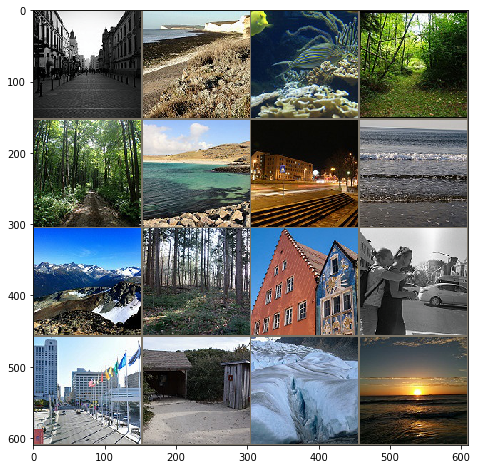

['street', 'sea', 'glacier', 'forest', 'forest', 'sea', 'street', 'sea', 'mountain', 'forest', 'buildings', 'street', 'street', 'street', 'glacier', 'sea']
['street', 'sea', 'sea', 'forest', 'forest', 'sea', 'street', 'sea', 'mountain', 'forest', 'buildings', 'street', 'street', 'buildings', 'glacier', 'sea']


In [32]:
ptr.eval()
out = ptr(xx.cuda())
preds = out.argmax(1)
predicted_classes = [image_datasets['dev'].classes[c] for c in preds]
actual_classes = [image_datasets['dev'].classes[c] for c in yy]
imshow(make_grid(xx, nrow=4), fig_size=(8,8))
print(predicted_classes)
print(actual_classes)

In [33]:
all_preds = []
correct_preds = []
with torch.no_grad():
    ptr.eval()
    for xx, yy in image_dataloaders['test']:
        xx = xx.to(device)
        output = ptr(xx)
        all_preds.extend(output.argmax(1).tolist())
        correct_preds.extend(yy.tolist())

In [34]:
from sklearn import metrics

In [35]:
all_preds = np.asarray(all_preds)
correct_preds = np.asarray(correct_preds)

In [36]:
target_names = image_datasets['test'].classes
print(metrics.classification_report(correct_preds, all_preds,target_names=target_names))

              precision    recall  f1-score   support

   buildings       0.83      0.74      0.78       437
      forest       0.91      0.97      0.94       474
     glacier       0.79      0.80      0.79       553
    mountain       0.76      0.84      0.80       525
         sea       0.86      0.82      0.84       510
      street       0.83      0.82      0.82       501

   micro avg       0.83      0.83      0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



In [37]:
confusion_matrix = metrics.confusion_matrix(correct_preds, all_preds)
pd.DataFrame(confusion_matrix, index=target_names, columns=target_names)

,buildings,forest,glacier,mountain,sea,street
buildings,323,11,2,13,20,68
forest,2,458,2,4,1,7
glacier,4,4,440,86,16,3
mountain,2,3,62,439,19,0
sea,10,4,43,31,416,6
street,46,23,7,2,13,410


№1

$f(\vec{u}) = -\sum_{i=1}^n p_i \log p_i ; ~ p_i = \frac{e^{u_i}} {\sum_{j=1}^n e^{u_j}}$

In [38]:
def grad_example(u):
    u = u.clone()
    u.requires_grad_(True)
    p = torch.exp(u)/torch.sum(torch.exp(u))
    f = -torch.sum(p*torch.log(p))
    f.backward()
    return u.grad

In [39]:
grad_example(torch.tensor([1.,1.,1.]))

tensor([3.7253e-09, 3.7253e-09, 3.7253e-09])